In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import SHIPS_ML_model_funcs
from utils import SHIPS_plotting
import matplotlib.colors
import os

##### Experiment info for both models

In [2]:
fpath_load = 'DATA/ML_model_results/TRAINING/all_models_ROS_and_SMOTE/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 25

##### Load experiments

In [3]:
path_suff = 'TRAIN_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.csv'.format(yr_start=train_yr_start,yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,N=N_samples,scoring=score)
cm_res = pd.read_csv(fpath_load+'Conf_Matrix'+path_suff)

#### Part 1. Plots from confusion matrix
We can make several plots with our confusion matrix results:
* Performance diagram for training data
* Box plots of PoD, FAR, CSI; Hits, and Misses

##### Performance diagram.  
This plot summarizes our results for the training data. For our bootstrapped training data, we show the median false alarm ratio / probability of detection values as well as a 95% confidence interval (error bars). It also shows us our results in the context of frequency bias (diagonal lines; are we over/underforecasting our event?) and critical success index (contours), which is another metric that summarizes hits, misses, and false alarms all together.  

In [4]:
fig_dir_save = 'Figures/TRAINING/'
if not os.path.exists(fig_dir_save):
    os.makedirs(fig_dir_save)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


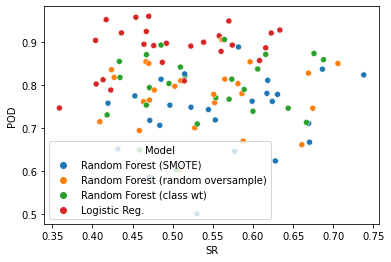

In [5]:
foo = cm_res.set_index(['Category Names','BASIN','Model']).xs(('RI','WEST_PACIFIC')).reset_index()
sns.scatterplot(data=foo,x='SR',y='POD',hue='Model')
foo.groupby('Model').median()
cm_res['Model'] = cm_res['Model'].replace('Random Forest (random oversample)','ROS')
cm_res['Model'] = cm_res['Model'].replace('Random Forest (SMOTE)','SMOTE')
cm_res['Model'] = cm_res['Model'].replace('Random Forest (class wt)','RFwt')



/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(


Text(0.5, 1.0, 'Training (2005-2018)')

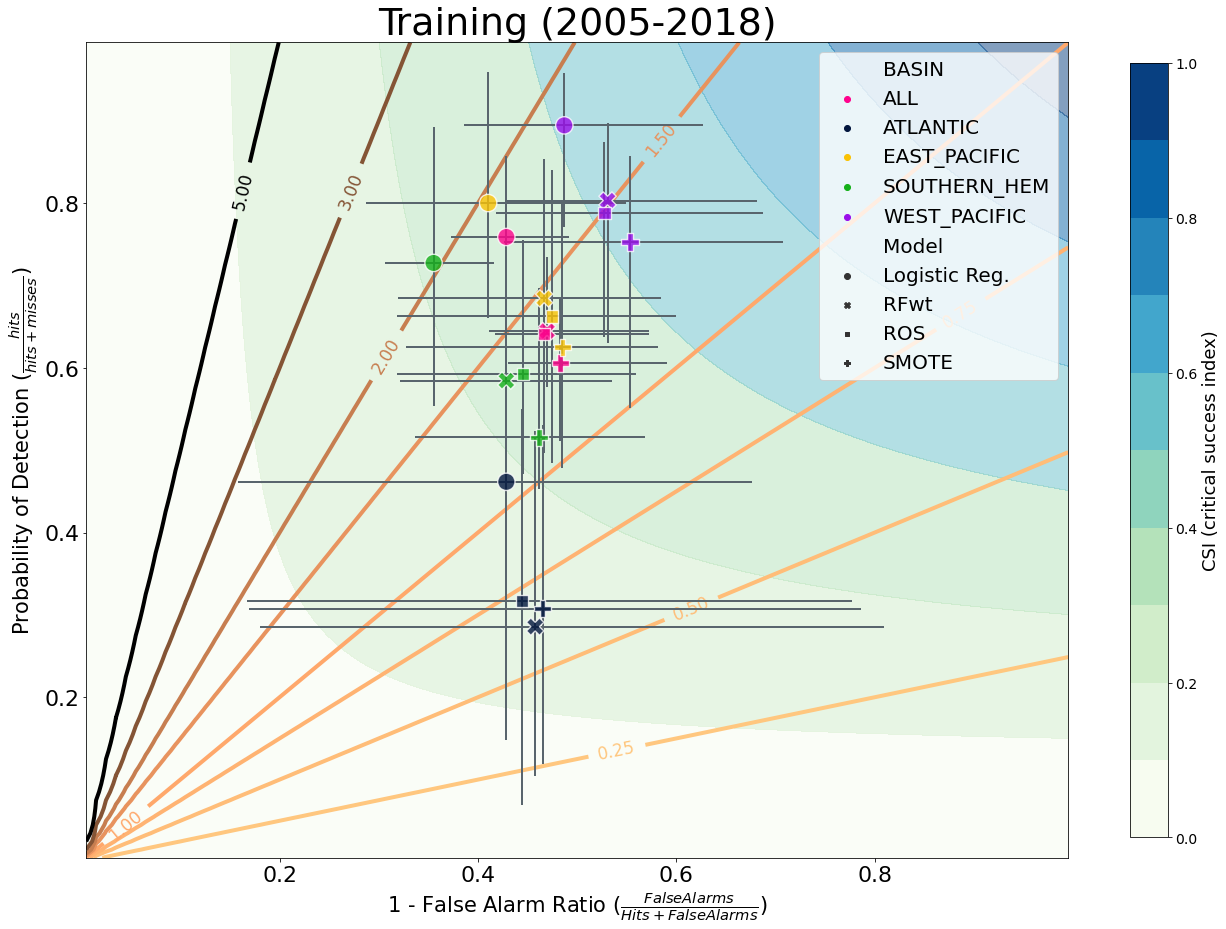

In [6]:
fig1,ax1 = plt.subplots(1,1,figsize=(22,15))
SHIPS_plotting.make_performance_diagram_background(ax1)
# Save empty PD in case we ever need it for a presentation
# fig1.savefig(fig_dir_save+'perf_diag_empty.png',format='png',dpi=350,bbox_inches='tight')
# fig1.savefig(fig_dir_save+'perf_diag_empty.pdf',format='pdf',bbox_inches='tight')
# Now, add results to PD
SHIPS_plotting.add_model_results(ax1,cm_res)
ax1.set_title('Training (2005-2018)',fontsize=38)
#
# fig1.savefig(fig_dir_save+'perf_diag_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig1.savefig(fig_dir_save+'perf_diag_TRAINING.pdf',format='pdf',bbox_inches='tight')


##### Get baseline
$$ Baseline = \frac{N_{yes}}{N_{yes} + N_{no}} $$

In [7]:
cm_group = cm_res.groupby(['BASIN','Model','Category Names','Fold']).mean()
baselines = cm_group.xs('RI',level=2)['N_actual']/cm_group.xs('not RI',level=2)['N_actual']

##### Get bias
$$ Bias = \frac{Hits + False Alarms}{Hits + Misses}$$

In [8]:
cm_res['BIAS'] = (cm_res['Hits']+cm_res['False Alarms'])/(cm_res['Hits'] + cm_res['Misses'])
basin_ALL = cm_res.sort_values(by='BASIN')['BASIN'].unique().tolist()

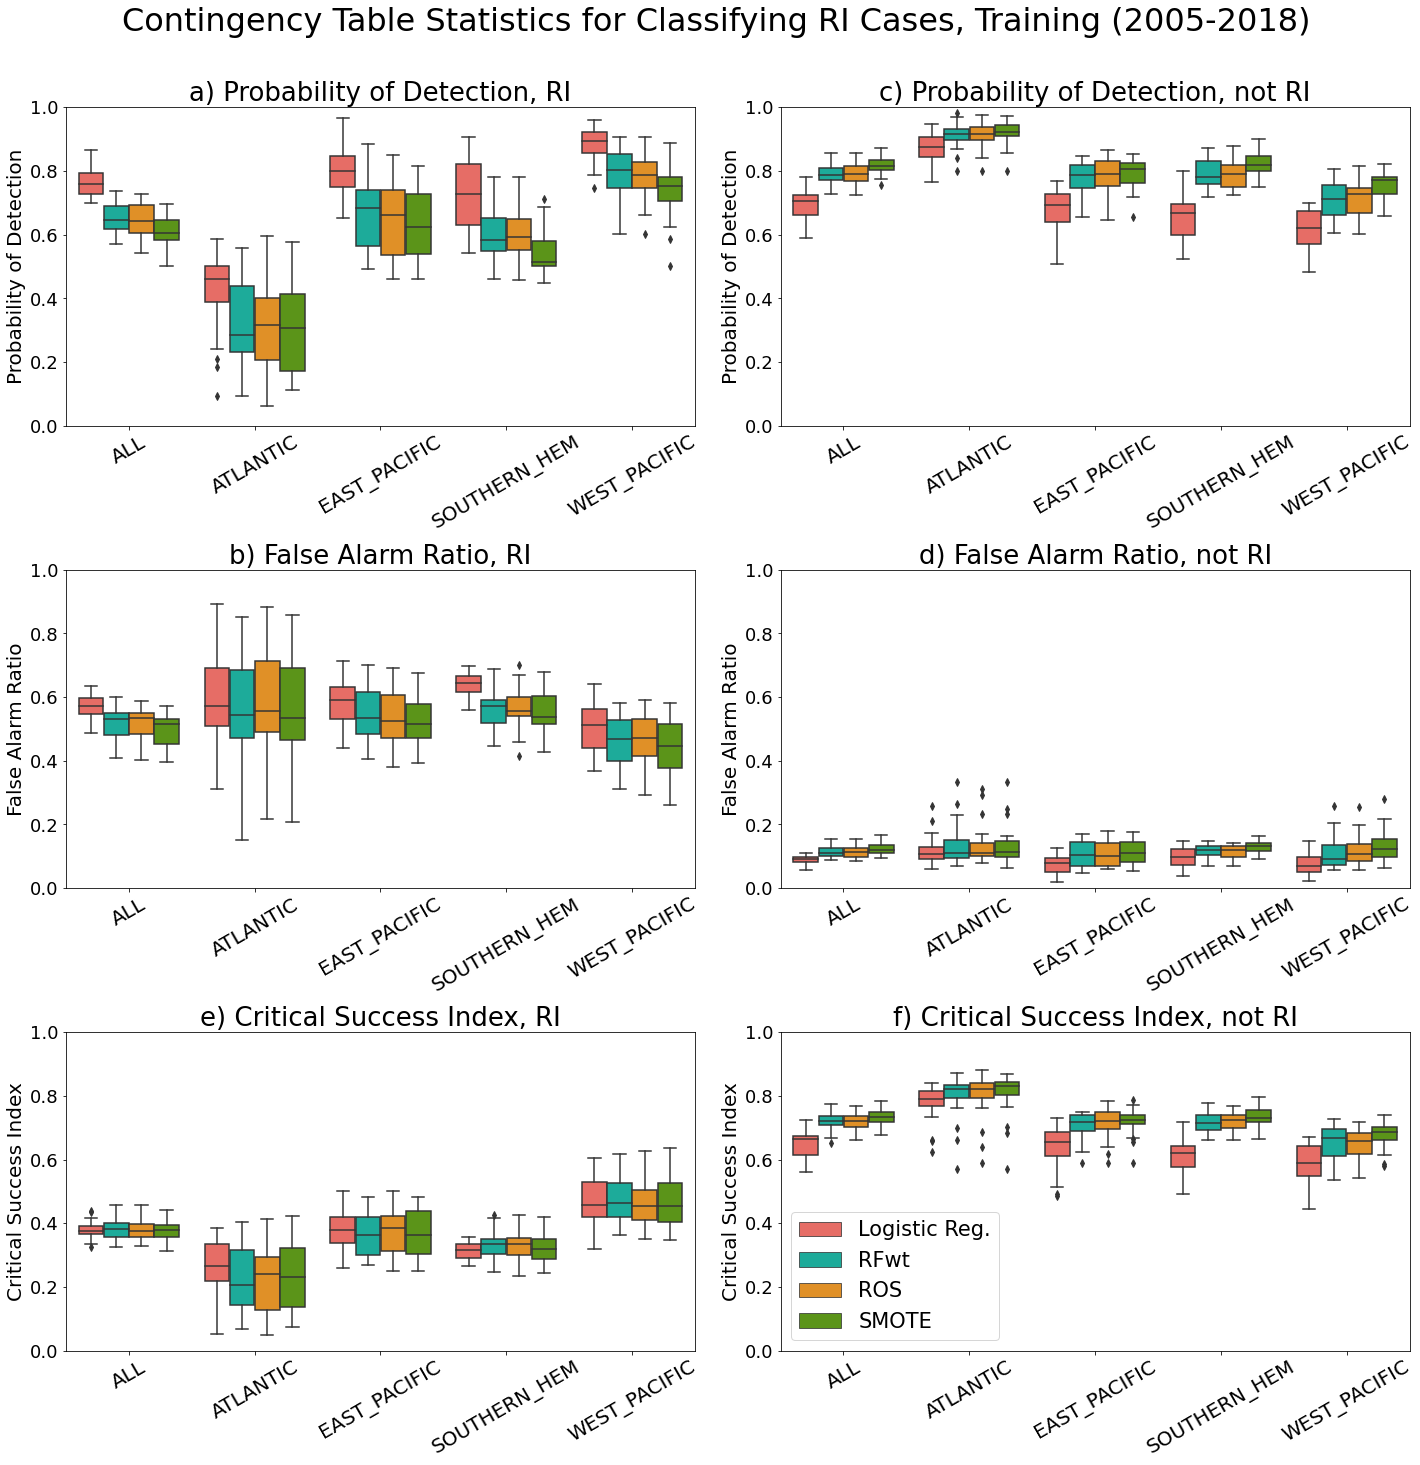

In [10]:
fig6,((ax6a,ax6b),(ax6c,ax6d),(ax6e,ax6f)) = plt.subplots(3,2,figsize=(20,20))
pal_2 = sns.color_palette(sns.xkcd_palette(['coral','turquoise','tangerine','leaf green']),4)
# pal_2 = 'magma'
cm_plt = cm_res.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.boxplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='POD',hue='Model',
            ax=ax6a,palette=sns.set_palette(pal_2))
ax6a.set_ylabel('Probability of Detection',fontsize=20)
ax6a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax6a.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6a.set_title('a) Probability of Detection, RI',fontsize=26)
ax6a.set_xlabel(None)
ax6a.set_ylim([0,1])
ax6a.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='FAR',
            hue='Model',ax=ax6c,palette=sns.set_palette(pal_2))
ax6c.set_ylabel('False Alarm Ratio',fontsize=20)
ax6c.legend(fontsize=12)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6c.set_title('b) False Alarm Ratio, RI',fontsize=26)
ax6c.set_xlabel(None)
ax6c.set_ylim([0,1])
ax6c.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='POD',hue='Model',ax=ax6b,palette=sns.set_palette(pal_2))
ax6b.set_ylabel('Probability of Detection',fontsize=20)
ax6b.legend(fontsize=12)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6b.set_title('c) Probability of Detection, not RI',fontsize=26)
ax6b.set_xlabel(None)
ax6b.tick_params(axis='y',labelsize=18)
ax6b.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='FAR',hue='Model',ax=ax6d,palette=sns.set_palette(pal_2))
ax6d.set_ylabel('False Alarm Ratio',fontsize=20)
# ax6d.legend(fontsize=18)
ax6d.get_legend().remove()
ax6d.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6d.set_title('d) False Alarm Ratio, not RI',fontsize=26)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y',labelsize=18)
ax6d.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6e,palette=sns.set_palette(pal_2))
ax6e.set_ylabel('Critical Success Index',fontsize=20)
#ax6e.legend(fontsize=18)
ax6e.get_legend().remove()
ax6e.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6e.set_title('e) Critical Success Index, RI',fontsize=26)
ax6e.set_xlabel(None)
ax6e.tick_params(axis='y',labelsize=18)
ax6e.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6f,palette=sns.set_palette(pal_2))
ax6f.set_ylabel('Critical Success Index',fontsize=20)
ax6f.legend(fontsize=21)
ax6f.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6f.set_title('f) Critical Success Index, not RI',fontsize=26)
ax6f.set_xlabel(None)
ax6f.tick_params(axis='y',labelsize=18)
ax6f.set_ylim([0,1])
#
fig6.suptitle('Contingency Table Statistics for Classifying RI Cases, Training (2005-2018)',fontsize=32,y=1.015)
fig6.tight_layout()
#
#fig6.savefig(fig_dir_save+'ETHICS_POD_FAR_CSI_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
#fig6.savefig(fig_dir_save+'ETHICS_POD_FAR_CSI_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Interquartile range
What's the difference between our 25th and 75th percentiles (i.e. the middle of our data)?

In [11]:
q25 = cm_plt_total.xs(('RI')).reset_index().groupby(['BASIN','Model'])[['POD','PFOD','FAR','Threat',
                                                                       'Hits','Misses','False Alarms']].quantile(0.25)
q75 = cm_plt_total.xs(('RI')).reset_index().groupby(['BASIN','Model'])[['POD','PFOD','FAR','Threat',
                                                                       'Hits','Misses','False Alarms']].quantile(0.75)
d = q75 - q25

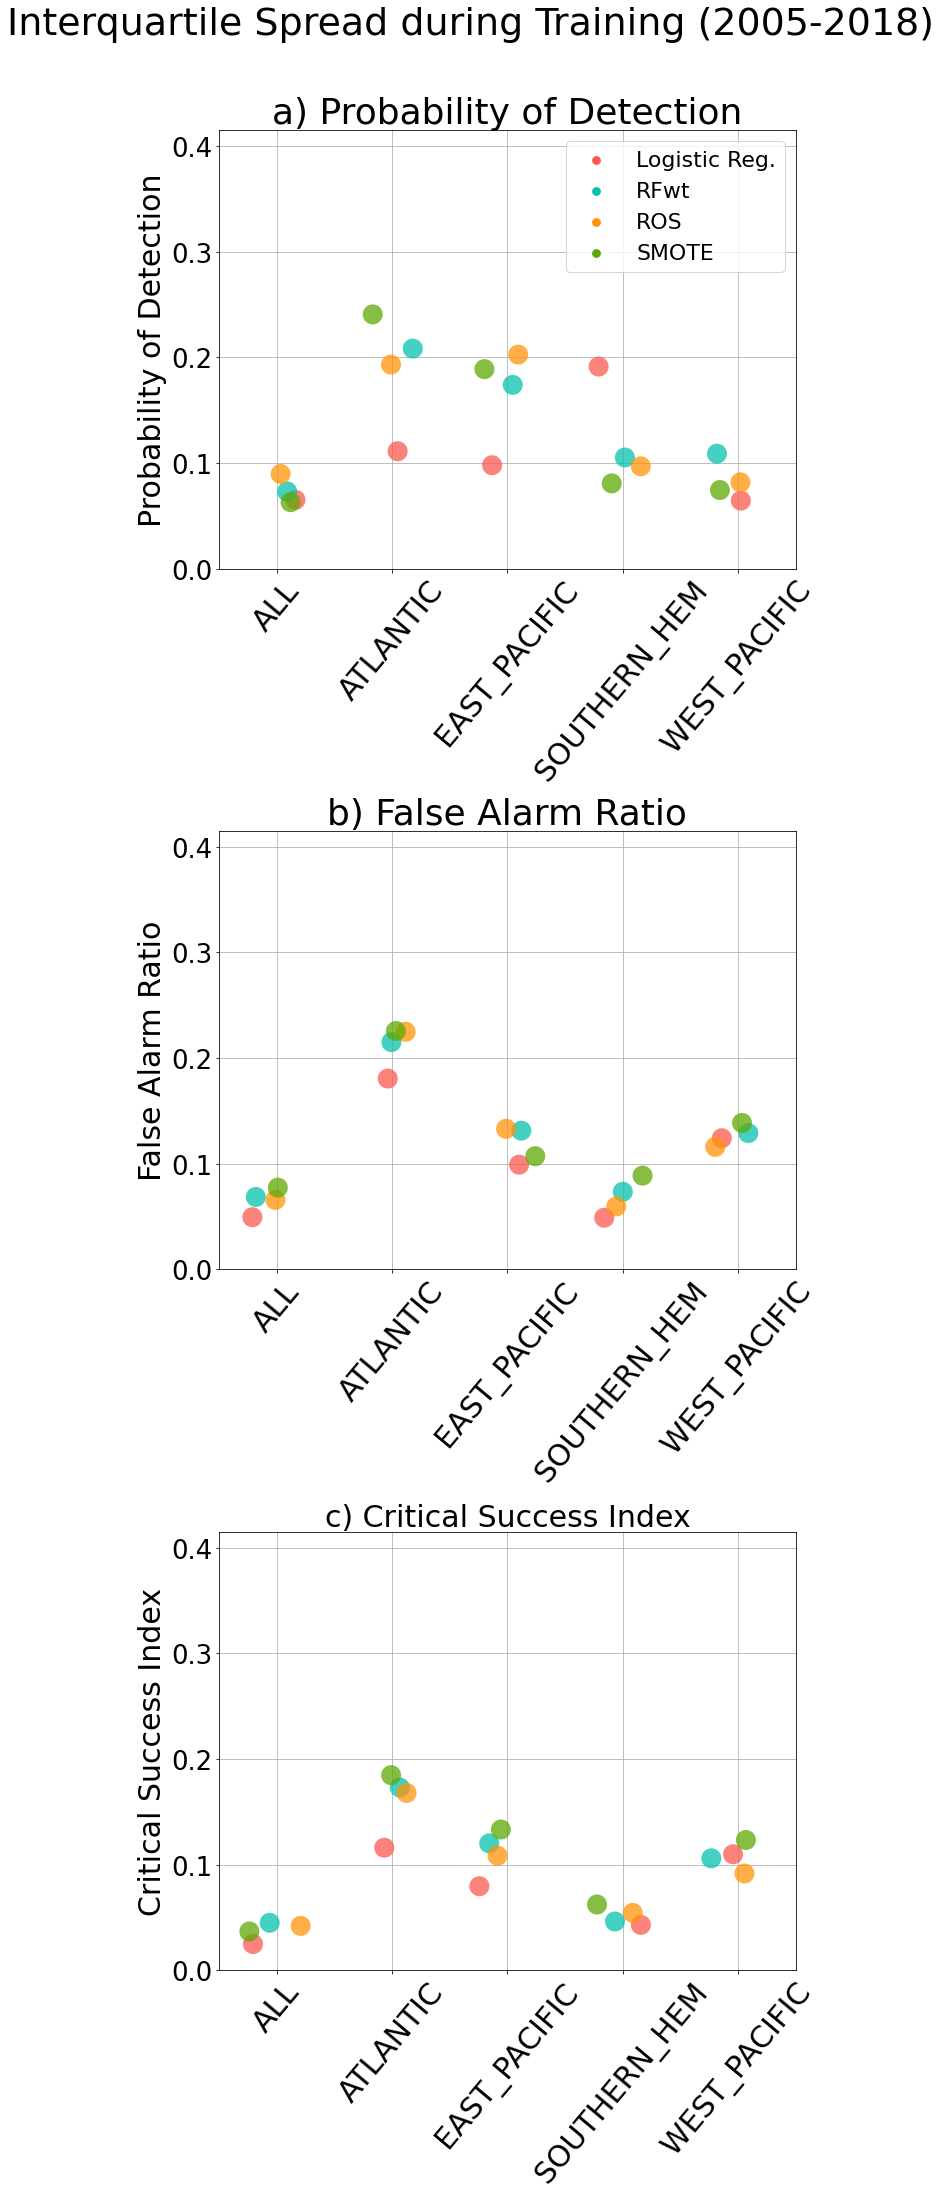

In [12]:
fig10,((ax10a,ax10b,ax10c)) = plt.subplots(3,1,figsize=(10,30))
pal_2 = sns.color_palette(sns.xkcd_palette(['coral','turquoise','tangerine','leaf green']),4)
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='POD',hue='Model',
            ax=ax10a,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax10a.set_ylabel('Probability of Detection',fontsize=30)
ax10a.grid()
#ax10a.get_legend().remove()
ax10a.legend(fontsize=22)
ax10a.set_xticklabels(basin_ALL,fontsize=30,rotation=50)
ax10a.set_title('a) Probability of Detection',fontsize=36)
ax10a.set_xlabel(None)
ax10a.set_ylim([0,0.415])
ax10a.tick_params(axis='y',labelsize=26)
#
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='FAR',hue='Model',
            ax=ax10b,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax10b.set_ylabel('False Alarm Ratio',fontsize=30)
ax10b.grid()
ax10b.get_legend().remove()
#ax10b.legend(fontsize=13)
ax10b.set_xticklabels(basin_ALL,fontsize=30,rotation=50)
ax10b.set_title('b) False Alarm Ratio',fontsize=36)
ax10b.set_xlabel(None)
ax10b.set_ylim([0,0.415])
ax10b.tick_params(axis='y',labelsize=26)
#
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Threat',hue='Model',
            ax=ax10c,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax10c.grid()
ax10c.set_ylabel('Critical Success Index',fontsize=30)
ax10c.get_legend().remove()
#ax10c.legend(fontsize=13)
ax10c.set_xticklabels(basin_ALL,fontsize=30,rotation=50)
ax10c.set_title('c) Critical Success Index',fontsize=30)
ax10c.set_xlabel(None)
ax10c.set_ylim([0,0.415])
ax10c.tick_params(axis='y',labelsize=26)
#
fig10.suptitle('Interquartile Spread during Training (2005-2018)',fontsize=38,y=1.015)
fig10.tight_layout()
# fig10.savefig(fig_dir_save+'ETHICS_IQR_POD_FAR_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig10.savefig(fig_dir_save+'ETHICS_IQR_POD_FAR_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Same but for hits, misses, false alarms

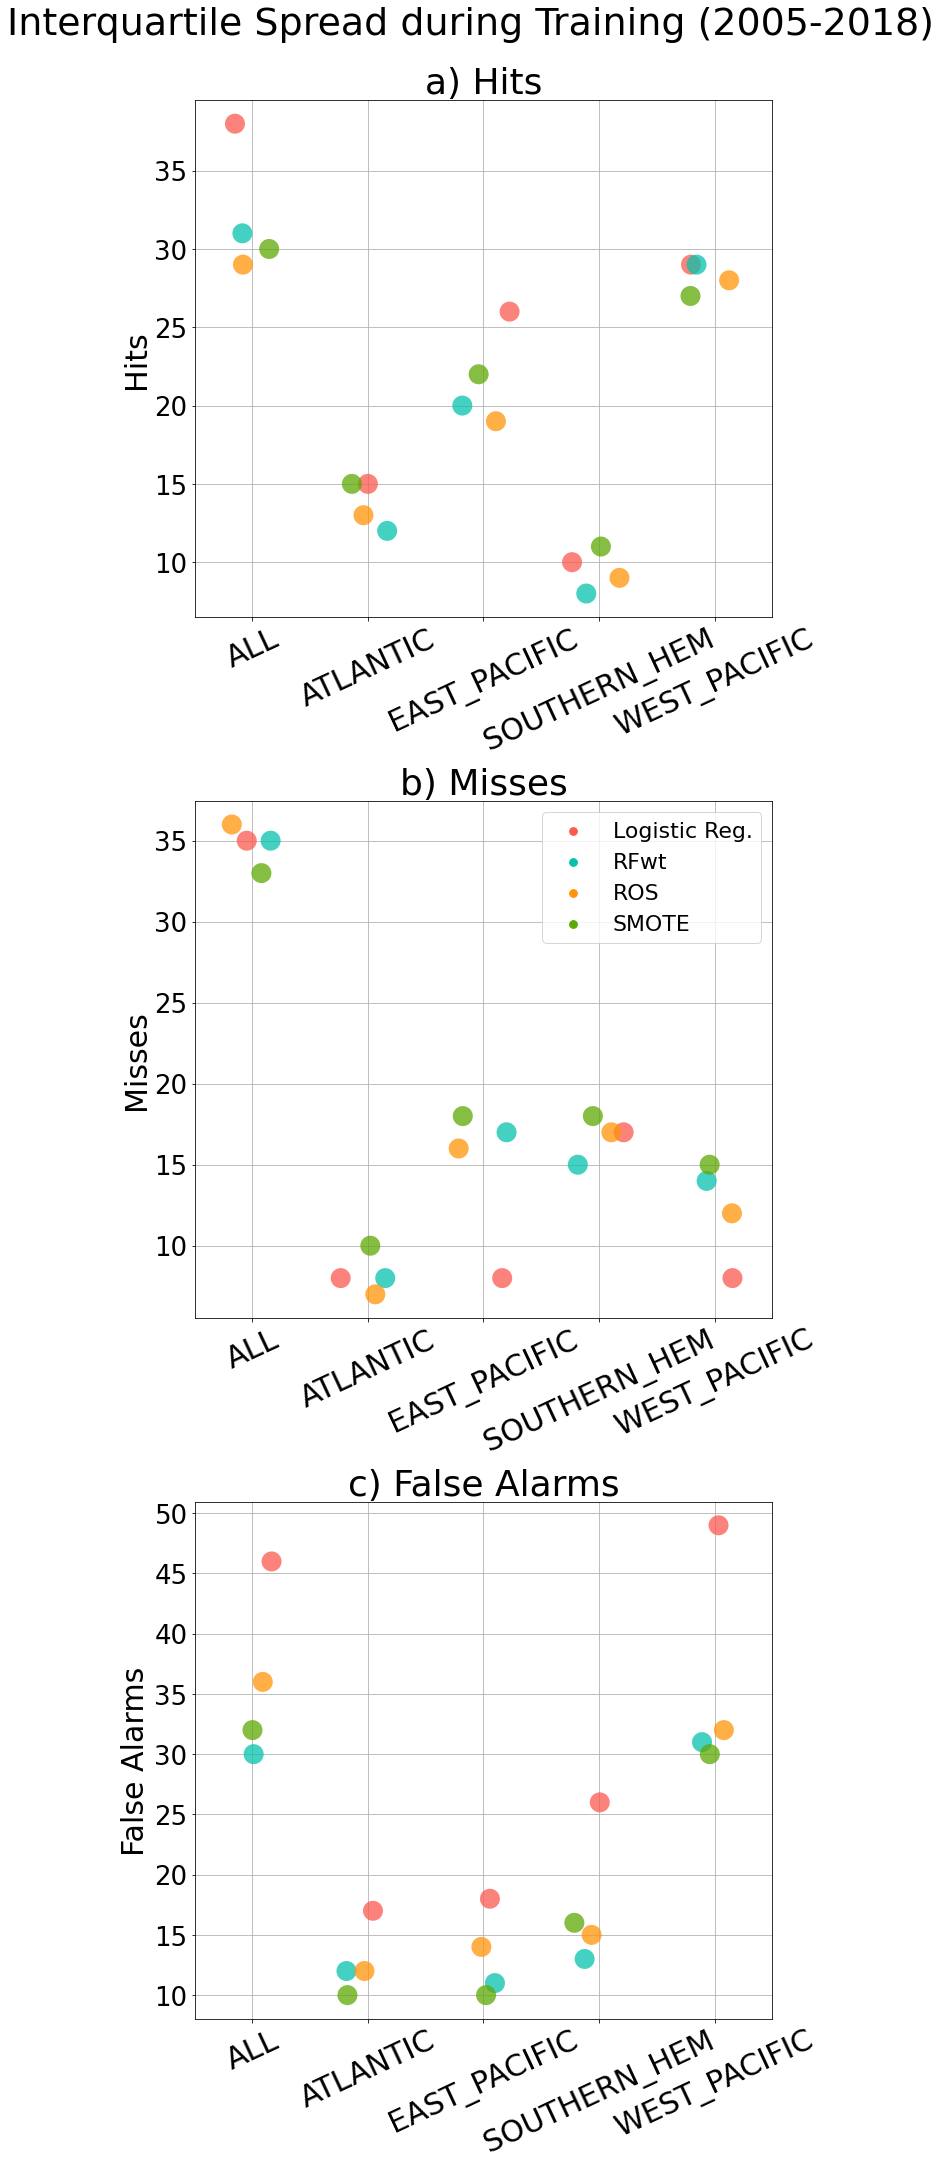

In [13]:
fig11,((ax11a,ax11b,ax11c)) = plt.subplots(3,1,figsize=(10,30))
# pal_2 = sns.color_palette(sns.xkcd_palette(['coral','turquoise','tangerine','leaf green']),4)
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Hits',hue='Model',
            ax=ax11a,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax11a.set_ylabel('Hits',fontsize=30)
ax11a.grid()
ax11a.get_legend().remove()
#ax11a.legend(fontsize=14)
ax11a.set_xticklabels(basin_ALL,fontsize=30,rotation=25)
ax11a.set_title('a) Hits',fontsize=36)
ax11a.set_xlabel(None)
# ax10a.set_ylim([0,0.415])
ax11a.tick_params(axis='y',labelsize=26)
#
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Misses',hue='Model',
            ax=ax11b,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax11b.set_ylabel('Misses',fontsize=30)
ax11b.grid()
#ax11b.get_legend().remove()
ax11b.legend(fontsize=22)
ax11b.set_xticklabels(basin_ALL,fontsize=30,rotation=25)
ax11b.set_title('b) Misses',fontsize=36)
ax11b.set_xlabel(None)
# ax10b.set_ylim([0,0.415])
ax11b.tick_params(axis='y',labelsize=26)
#
sns.stripplot(data=d.sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='False Alarms',hue='Model',
            ax=ax11c,palette=sns.set_palette(pal_2),s=20,alpha=0.75,jitter=0.25)
ax11c.grid()
ax11c.set_ylabel('False Alarms',fontsize=30)
ax11c.get_legend().remove()
#ax11c.legend(fontsize=12)
ax11c.set_xticklabels(basin_ALL,fontsize=30,rotation=25)
ax11c.set_title('c) False Alarms',fontsize=36)
ax11c.set_xlabel(None)
# ax11c.set_ylim([0,0.415])
ax11c.tick_params(axis='y',labelsize=26)
#
fig11.suptitle('Interquartile Spread during Training (2005-2018)',fontsize=38,y=1.001)
fig11.tight_layout()
# fig11.savefig(fig_dir_save+'ETHICS_IQR_hits_misses_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig11.savefig(fig_dir_save+'ETHICS_IQR_hits_misses_TRAINING.pdf',format='pdf',bbox_inches='tight')

In [14]:
d.sort_values(['BASIN','Model']).xs('ATLANTIC')

,POD,PFOD,FAR,Threat,Hits,Misses,False Alarms
Model,,,,,,,
Logistic Reg.,0.111111,0.063758,0.180672,0.115942,15.0,8.0,17.0
RFwt,0.208255,0.033345,0.215126,0.172932,12.0,8.0,12.0
ROS,0.193103,0.041950,0.224924,0.167809,13.0,7.0,12.0
SMOTE,0.240630,0.035860,0.225641,0.184624,15.0,10.0,10.0


##### Hits, Misses, False Alarms

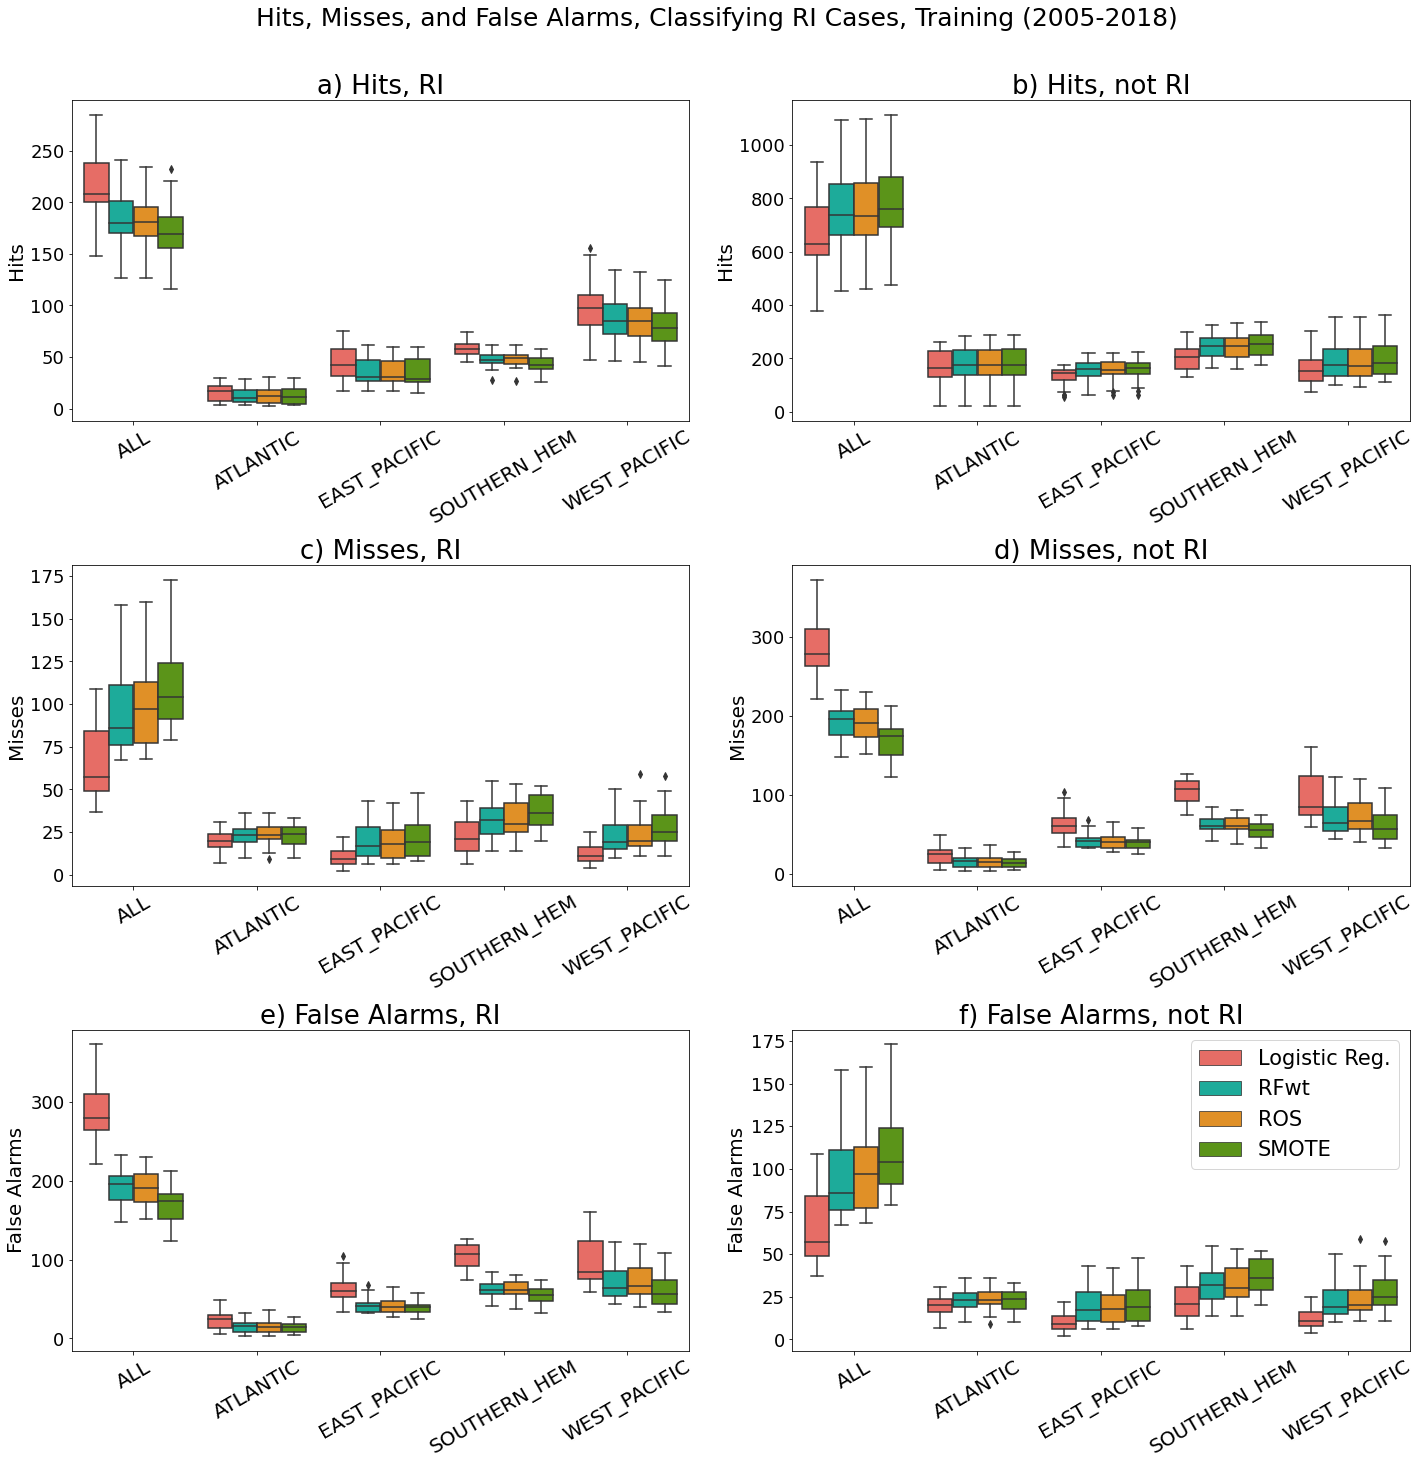

In [15]:
fig2,((ax2a,ax2b),(ax2c,ax2d),(ax2e,ax2f)) = plt.subplots(3,2,figsize=(20,20))
sns.boxplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Hits',hue='Model',
            ax=ax2a,palette=sns.set_palette(pal_2))
ax2a.set_ylabel('Hits',fontsize=20)
ax2a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax2a.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2a.set_title('a) Hits, RI',fontsize=26)
ax2a.set_xlabel(None)
# ax6a.set_ylim([0,1])
ax2a.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Misses',
            hue='Model',ax=ax2c,palette=sns.set_palette(pal_2))
ax2c.set_ylabel('Misses',fontsize=20)
ax2c.legend(fontsize=12)
ax2c.get_legend().remove()
ax2c.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2c.set_title('c) Misses, RI',fontsize=26)
ax2c.set_xlabel(None)
# ax6c.set_ylim([0,1])
ax2c.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Hits',hue='Model',ax=ax2b,palette=sns.set_palette(pal_2))
ax2b.set_ylabel('Hits',fontsize=20)
ax2b.legend(fontsize=12)
ax2b.get_legend().remove()
ax2b.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2b.set_title('b) Hits, not RI',fontsize=26)
ax2b.set_xlabel(None)
ax2b.tick_params(axis='y',labelsize=18)
# ax6b.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Misses',hue='Model',ax=ax2d,palette=sns.set_palette(pal_2))
ax2d.set_ylabel('Misses',fontsize=20)
# ax6d.legend(fontsize=18)
ax2d.get_legend().remove()
ax2d.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2d.set_title('d) Misses, not RI',fontsize=26)
ax2d.set_xlabel(None)
ax2d.tick_params(axis='y',labelsize=18)
# ax6d.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2e,palette=sns.set_palette(pal_2))
ax2e.set_ylabel('False Alarms',fontsize=20)
#ax6e.legend(fontsize=18)
ax2e.get_legend().remove()
ax2e.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2e.set_title('e) False Alarms, RI',fontsize=26)
ax2e.set_xlabel(None)
ax2e.tick_params(axis='y',labelsize=18)
# ax6e.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2f,palette=sns.set_palette(pal_2))
ax2f.set_ylabel('False Alarms',fontsize=20)
ax2f.legend(fontsize=21)
ax2f.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2f.set_title('f) False Alarms, not RI',fontsize=26)
ax2f.set_xlabel(None)
ax2f.tick_params(axis='y',labelsize=18)
# ax6f.set_ylim([0,1])
#
fig2.suptitle('Hits, Misses, and False Alarms, Classifying RI Cases, Training (2005-2018)',fontsize=25,y=1.015)
fig2.tight_layout()
#
# fig2.savefig(fig_dir_save+'ETHICS_HIT_MISS_FA_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig2.savefig(fig_dir_save+'ETHICS_HIT_MISS_FA_TRAINING.pdf',format='pdf',bbox_inches='tight')

Hits, misses, FA--RI only

In [16]:
all_sel = cm_plt_total.xs(('RI','ALL')).reset_index()
xx = all_sel[['Model','Fold','Hits']]
xx['Category'] = 'Hits'
xx = xx.rename(columns={'Hits':'Number'})
yy = all_sel[['Model','Fold','Misses']]
yy['Category'] = 'Misses'
yy = yy.rename(columns={'Misses':'Number'})
zz = all_sel[['Model','Fold','False Alarms']]
zz['Category'] = 'False Alarms'
zz = zz.rename(columns={'False Alarms':'Number'})
##
plt_all_RI = pd.concat([xx,yy,zz])
plt_all_RI['Model'] = plt_all_RI['Model'].replace(to_replace='RFwt',value='RF class weight',regex=True)
plt_all_RI['Model'] = plt_all_RI['Model'].replace(to_replace='ROS',value='RF random oversample',regex=True)
plt_all_RI['Model'] = plt_all_RI['Model'].replace(to_replace='SMOTE',value='RF smote',regex=True)


/tmp/ipykernel_404970/3007950068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['Category'] = 'Hits'
/tmp/ipykernel_404970/3007950068.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yy['Category'] = 'Misses'
/tmp/ipykernel_404970/3007950068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

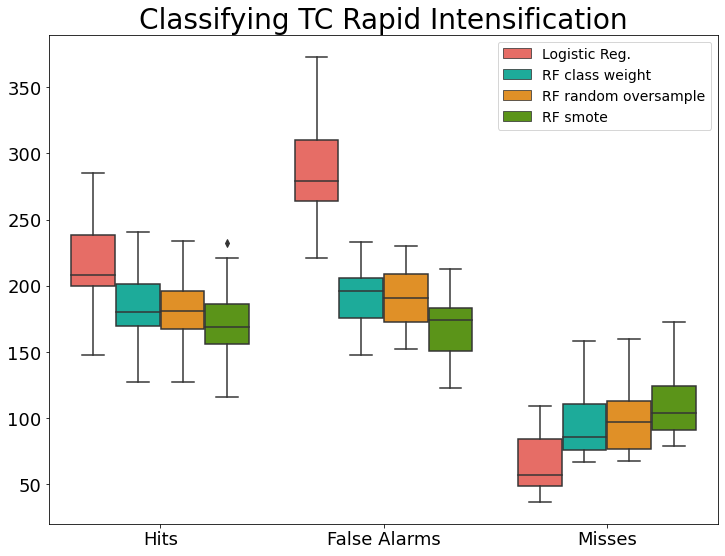

In [17]:
fig2,ax2a = plt.subplots(1,1,figsize=(12,9))
sns.boxplot(data=plt_all_RI.sort_values(['Model']).reset_index(),x='Category',y='Number',hue='Model',
            ax=ax2a,palette=pal_2)
#
ax2a.set_xlabel(None)
ax2a.set_ylabel(None)
ax2a.tick_params(axis='both',which='major',labelsize=18)
ax2a.legend(fontsize=14)
ax2a.set_title('Classifying TC Rapid Intensification',fontsize=28)
fig2.savefig(fig_dir_save+'ETHICS_hits_misses_FA.pdf',format='pdf',bbox_inches='tight')
fig2.savefig(fig_dir_save+'ETHICS_hits_misses_FA.png',format='png',dpi=350,bbox_inches='tight')

ValueError: Could not interpret input 'BASIN'

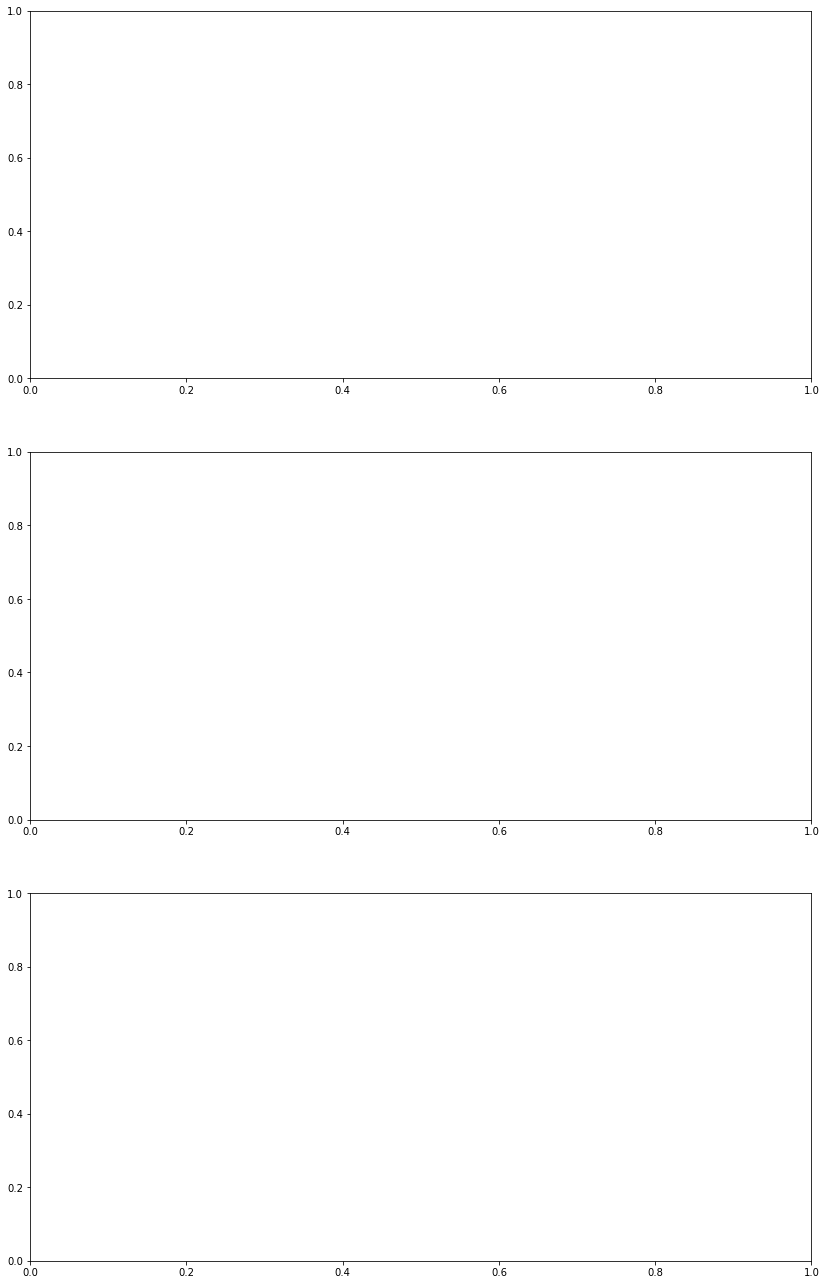

In [18]:
fig2,((ax2a,ax2b,ax2c)) = plt.subplots(3,1,figsize=(14,23))
sns.boxplot(data=all_sel.sort_values(['Model']).reset_index(),x='BASIN',y='Hits',hue='Model',
            ax=ax2a,palette=sns.set_palette(pal_2))
ax2a.set_ylabel('Hits',fontsize=20)
ax2a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax2a.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2a.set_title('a) Hits, RI',fontsize=26)
ax2a.set_xlabel(None)
# ax6a.set_ylim([0,1])
ax2a.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Misses',
            hue='Model',ax=ax2b,palette=sns.set_palette(pal_2))
ax2b.set_ylabel('Misses',fontsize=20)
ax2b.legend(fontsize=12)
ax2b.get_legend().remove()
ax2b.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2b.set_title('c) Misses, RI',fontsize=26)
ax2b.set_xlabel(None)
# ax6c.set_ylim([0,1])
ax2b.tick_params(axis='y',labelsize=18)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2c,palette=sns.set_palette(pal_2))
ax2c.set_ylabel('False Alarms',fontsize=20)
ax2c.legend(fontsize=18)
ax2c.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax2c.set_title('e) False Alarms, RI',fontsize=26)
ax2c.set_xlabel(None)
ax2c.tick_params(axis='y',labelsize=18)
# ax6e.set_ylim([0,1])
fig2.suptitle('Hits, Misses, and False Alarms, Classifying RI Cases, Training (2005-2018)',fontsize=25,y=1.015)
fig2.tight_layout()
#
# fig2.savefig(fig_dir_save+'HIT_MISS_FA_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig2.savefig(fig_dir_save+'HIT_MISS_FA_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Load precision vs recall curves

In [ ]:
prec_vs_rec = pd.read_csv(fpath_load+'Prec_vs_recall'+path_suff)
prec_vs_rec['Model'] = prec_vs_rec['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})


##### Get performance diagram curves from precision vs recall data

In [ ]:
pd_curves = SHIPS_ML_model_funcs.calculate_PD_curves(prec_vs_rec)
metric_plt = 'max'
basin_use = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
basin_label = ['a)','b)','c)','d)']
for ibasin in np.arange(0,len(basin_use)):
    basin_sel = basin_use[ibasin]
    basin_lett = basin_label[ibasin]
    fig3,ax3 = plt.subplots(1,1,figsize=(12,8))
    SHIPS_plotting.make_performance_diagram_background(ax3)
    SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,ax3,basin_sel,metric_plt)
    ax3.set_title('{lett} Best Performance, Identifying RI, {basin}, Training (2005-2018)'.format(
        lett=basin_lett,basin=basin_sel),fontsize=22)
    fig3.tight_layout()
    # fig3.savefig(fig_dir_save+'ETHICS_PD_curves_best_{basin}_TRAINING.png'.format(basin=basin_sel),format='png',dpi=350,bbox_inches='tight')
    # fig3.savefig(fig_dir_save+'ETHICS_PD_curves_best_{basin}_TRAINING.pdf'.format(basin=basin_sel),format='pdf',bbox_inches='tight')

In [ ]:
fig3,ax3 = plt.subplots(1,1,figsize=(12,8))
SHIPS_plotting.make_performance_diagram_background(ax3)
SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,ax3,'ALL',metric_plt)
ax3.set_title('Best Performance, Identifying RI, {basin}, Training (2005-2018)'.format(
        basin='ALL'),fontsize=24)
fig3.tight_layout()
# fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TRAINING.png'.format(basin='ALL'),format='png',dpi=350,bbox_inches='tight')
# fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TRAINING.pdf'.format(basin='ALL'),format='pdf',bbox_inches='tight')

In [ ]:
fig13,ax13 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax13.flatten()
letters = ['a)','b)','c)','d)','e)','f)']
for i in np.arange(0,len(ax_sel)):
    iax = ax_sel[i]
    if i == 5:
        SHIPS_plotting.make_performance_diagram_background(iax)
        # Save empty PD in case we ever need it for a presentation
        SHIPS_plotting.add_model_results(iax,cm_res)
        iax.set_title('{lett} Training (2005-2018)'.format(lett=letters[i]),fontsize=32)
        iax.legend(fontsize=14,markerscale=2)
    else:
        SHIPS_plotting.make_performance_diagram_background(iax)
        SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,iax,basin_ALL[i],metric_plt)
        iax.set_ylabel(r"Probability of Detection (${\frac{hits}{hits+misses}})$",fontsize=24)
        iax.set_xlabel(r"1 - False Alarm Ratio (${\frac{False Alarms}{Hits + False Alarms}})$",fontsize=24)
        iax.set_title('{lett} {basin}'.format(lett=letters[i],basin=basin_ALL[i]),fontsize=32)
        if i != 0:
            iax.get_legend().remove()
#
#fig13.delaxes(ax_sel[5])
fig13.suptitle('Best Performance, Training (2005 - 2018)',fontsize=38,y=1.001)

fig13.tight_layout()
# fig13.savefig(fig_dir_save+'PD_curves_best_all_panels_TRAIN.png',format='png',dpi=350,bbox_inches='tight')
# fig13.savefig(fig_dir_save+'PD_curves_best_all_panels_TRAIN.pdf',format='pdf',bbox_inches='tight')

#### Bias @ median CSI

In [ ]:
CM_RI = cm_res.set_index(['Category','BASIN','Model']).xs((1.0))
median_CSI = pd.DataFrame()
for ibasin in basin_ALL:
# ibasin = 'ALL'
    threat_sort = CM_RI.sort_values(by=['BASIN','Model','Threat'],ascending=False).xs(ibasin)
    threat_med = threat_sort.reset_index().iloc[np.arange(0,100,25)]
    threat_med['BASIN'] = ibasin
    median_CSI = median_CSI.append(threat_med.reset_index(),ignore_index=True)

In [ ]:
CM_RI.groupby(['BASIN','Model'])['N_predicted','N_actual'].min()

In [ ]:
median_CSI[['Model','N_predicted','N_actual','Threat','POD','BASIN','Hits','FAR','Years Out']]

In [ ]:
fig5,ax5 = plt.subplots(1,1,figsize=(12,9))
colors_list = ['hot pink','navy','goldenrod','green','violet']
pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),5)
#use_pal = sns.set_palette({'xkcd:hot pink','xkcd:navy','xkcd:goldenrod','xkcd:green','xkcd:violet'},5)
#sns.scatterplot(data=foo.reset_index().sort_values(by='Model'),x='Threat',y='BIAS',hue='Model',
 #               ax=ax5)
sns.scatterplot(data=median_CSI.sort_values(by=['Model','BASIN']),x='Threat',y='BIAS',
                hue='BASIN',style='Model',s=400,ax=ax5,palette=sns.set_palette(pal_sel))
ax5.set_xlabel('Critical Success Index',fontsize=24)
ax5.set_ylabel('Frequency Bias',fontsize=24)
ax5.set_xlim([0,0.705])
ax5.axhline(1,color='xkcd:slate gray',linewidth=4,linestyle='--')
ax5.legend(fontsize=17,bbox_to_anchor=[0,0,1.15,0.975],markerscale=2)
ax5.grid()
ax5.tick_params(axis='x',labelsize=16)
ax5.tick_params(axis='y',labelsize=16)
ax5.set_title('Frequency Bias at Maximum CSI',fontsize=36)
fig5.tight_layout()
# fig5.savefig(fig_dir_save+'bias_vs_CSI_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig5.savefig(fig_dir_save+'bias_vs_CSI_TRAINING.pdf',format='pdf',bbox_inches='tight')

#### Bias, POD, and SR at maximum CSI

In [ ]:
fig15,(ax15a,ax15b,ax15c) = plt.subplots(3,1,figsize=(12,20))
# BIAS
sns.scatterplot(data=median_CSI.sort_values(by=['Model','BASIN']),x='Threat',y='BIAS',
                hue='BASIN',style='Model',s=400,ax=ax15a,palette=sns.set_palette(pal_sel))
ax15a.set_xlabel('Critical Success Index',fontsize=24)
ax15a.set_ylabel('Frequency Bias',fontsize=24)
ax15a.set_xlim([0,0.705])
ax15a.axhline(1,color='xkcd:slate gray',linewidth=4,linestyle='--')
ax15a.legend(fontsize=17,bbox_to_anchor=[0,0,1.15,0.975])
ax15a.get_legend().remove()
ax15a.grid()
ax15a.tick_params(axis='x',labelsize=16)
ax15a.tick_params(axis='y',labelsize=16)
ax15a.set_title('a) Frequency Bias',fontsize=28)
## POD
sns.scatterplot(data=median_CSI.sort_values(by=['Model','BASIN']),x='Threat',y='POD',
                hue='BASIN',style='Model',s=400,ax=ax15b,palette=sns.set_palette(pal_sel))
ax15b.set_xlabel('Critical Success Index',fontsize=24)
ax15b.set_ylabel('Probability of Detection',fontsize=21)
ax15b.set_xlim([0,.705])
ax15b.set_ylim([0,1.05])
#ax15a.axhline(1,color='xkcd:slate gray',linewidth=4,linestyle='--')
ax15b.legend(fontsize=17,bbox_to_anchor=[0,0,1.15,0.975],markerscale=2)
#ax15b.get_legend().remove()
ax15b.grid()
ax15b.tick_params(axis='x',labelsize=16)
ax15b.tick_params(axis='y',labelsize=16)
ax15b.set_title('b) Probability of Detection',fontsize=28)
## SR
sns.scatterplot(data=median_CSI.sort_values(by=['Model','BASIN']),x='Threat',y='SR',
                hue='BASIN',style='Model',s=400,ax=ax15c,palette=sns.set_palette(pal_sel))
ax15c.set_xlabel('Critical Success Index',fontsize=24)
ax15c.set_ylabel('Success Ratio',fontsize=24)
ax15c.set_xlim([0,0.705])
ax15c.set_ylim([0.25,.75])
# ax15c.axhline(1,color='xkcd:slate gray',linewidth=4,linestyle='--')
ax15c.legend(fontsize=17,bbox_to_anchor=[0,0,1.15,0.975])
ax15c.get_legend().remove()
ax15c.grid()
ax15c.tick_params(axis='x',labelsize=16)
ax15c.tick_params(axis='y',labelsize=16)
ax15c.set_title('c) Success Ratio',fontsize=28)
##
fig15.suptitle('Model Performance at Maximum CSI',y=0.99,fontsize=38)
fig15.tight_layout()
# fig15.savefig(fig_dir_save+'bias_pod_SR_vs_CSI_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
# fig15.savefig(fig_dir_save+'bias_pod_SR_vs_CSI_TRAINING.pdf',format='pdf',bbox_inches='tight')

In [ ]:
median_CSI.set_index(['BASIN','Model']).xs('ALL')

#### Precision vs recall curves

In [ ]:
p_vs_r = prec_vs_rec.set_index(['CLASS','BASIN','Model']).xs('RI')
p_vs_r['Pr'] = p_vs_r['Precision'].round(2)
p_vs_r['Rr'] = p_vs_r['Recall'].round(2)

In [ ]:
lett = ['a)','b)','c)','d)','e)']
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    fig6,ax6 = plt.subplots(1,1,figsize=(12,9))
    sns.lineplot(data=p_vs_r.xs(ibasin).reset_index().sort_values(by='Model'),x='Rr',y='Pr',hue='Model',
             palette=sns.set_palette(pal_2),ax=ax6,
            linewidth=4)
    ax6.legend(fontsize=18)
    ax6.set_ylim([-0.05,1.05])
    ax6.set_xlabel('Recall Score',fontsize=26)
    ax6.set_ylabel('Precision Score',fontsize=26)
    ax6.tick_params(axis='x',labelsize=18)
    ax6.tick_params(axis='y',labelsize=18)
    base_max = baselines.xs(ibasin).max()
    base_min = baselines.xs(ibasin).min()
    ax6.grid()
    ax6.axhspan(base_min,base_max,0,1,color='xkcd:light grey',alpha=0.85,label='Baseline')
    ax6.set_title('{ilett} Precision Score vs Recall Score, {basin}'.format(ilett=ilett,basin=ibasin),fontsize=32)
    #
    fig6.tight_layout()
    # fig6.savefig(fig_dir_save+'prec_vs_rec_{basin}_TRAINING.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
   #  fig6.savefig(fig_dir_save+'prec_vs_rec_{basin}_TRAINING.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

##### Prec vs rec all panels

In [ ]:
fig16,ax16 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax16.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    sns.lineplot(data=p_vs_r.xs(ibasin).reset_index().groupby(['Model','Rr','Pr']).mean().reset_index().sort_values(by='Model'),
                 x='Rr',y='Pr',hue='Model',palette=sns.set_palette(pal_2),ax=iax,linewidth=5)
    iax.set_ylim([-0.05,1.05])
    iax.set_xlabel('Recall Score',fontsize=24)
    iax.set_ylabel('Precision Score',fontsize=24)
    iax.tick_params(axis='x',labelsize=16)
    iax.tick_params(axis='y',labelsize=16)
    #base_max = baselines.xs(ibasin).max()
    #base_min = baselines.xs(ibasin).min()
    iax.grid()
    base_max = baselines.xs(ibasin).max()
    base_min = baselines.xs(ibasin).min()
    iax.grid()
    iax.axhspan(base_min,base_max,0,1,color='xkcd:light grey',alpha=0.85,label='Baseline')
    leg = iax.legend(fontsize=21)
    #
    if j != 1:
        iax.get_legend().remove()
    else:
        for line in leg.get_lines():
            line.set_linewidth(6.0)
    #
    iax.set_title('{ilett} {ibasin}'.format(ilett=ilett,ibasin=ibasin),fontsize=28)
        #iax.set_title('{ilett} ROC-AUC Curve, {ibasin}, 2019-2021'.format(ilett=ilett,ibasin=ibasin),fontsize=24)
    #
fig16.delaxes(ax_sel[5])
fig16.suptitle('Precision Score vs Recall Score, Training (2005 - 2018)',fontsize=38,y=1.015)
fig16.tight_layout()
# fig16.savefig(fig_dir_save+'prec_vs_rec_all_panels_TRAIN.png',format='png',dpi=350,bbox_inches='tight')
# fig16.savefig(fig_dir_save+'prec_vs_rec_all_panels_TRAIN.pdf',format='pdf',bbox_inches='tight')


#### AUC/ROC score

In [ ]:
roc_auc = cm_res = pd.read_csv(fpath_load+'ROC_AUC_vals'+path_suff)
roc_auc['Model'] = roc_auc['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})
# basin_sel = 'ALL'
models_ALL = roc_auc.sort_values(by='Model')['Model'].unique()

In [ ]:
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    #
    roc_vals_plt = roc_auc.set_index(['BASIN']).xs(ibasin).reset_index()
    roc_vals_plt[['FPR round','TPR round']] = roc_vals_plt[['False Positive Rate','True Positive Rate']].round(2)
    # 
    fig7,ax7 = plt.subplots(1,1,figsize=(12,9))
    # use_pal = sns.set_palette({'xkcd:turquoise','xkcd:coral','xkcd:tangerine','xkcd:leaf green'})
    sns.lineplot(data=roc_vals_plt.sort_values(by='Model'),x='FPR round',y='TPR round',hue='Model',ax=ax7,
                palette=sns.set_palette(pal_2),alpha=0.9,linewidth=5)
    ax7.plot([0,1],[0,1],color='k',linewidth=3)
    ax7.set_xlabel('False Positive Rate',fontsize=24)
    ax7.set_ylabel('True Positive Rate',fontsize=24)
    ax7.tick_params(axis='x',labelsize=16)
    ax7.tick_params(axis='y',labelsize=16)
    leg1 = ax7.legend(fontsize=17)
    for line in leg1.get_lines():
        line.set_linewidth(4.0)
    ax7.grid()
    #
    for imod in np.arange(0,len(models_ALL)):
        ax7.axhline(y=roc_vals_plt.groupby(['Model'])['AUC ROC Score'].max().iloc[imod],color=sns.color_palette()[imod],
                   linewidth=3)
    ax7.set_title('{ilett} ROC-AUC Curve, {ibasin}'.format(ilett=ilett,ibasin=ibasin),fontsize=28)
    #
    fig7.tight_layout()
    # fig7.savefig(fig_dir_save+'roc_auc_{basin}_TRAINING.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
    # fig7.savefig(fig_dir_save+'roc_auc_{basin}_TRAINING.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

##### ROC - AUC for all panels

In [ ]:
fig17,ax17 = plt.subplots(3,2,figsize=(20,20))
ax_sel = ax17.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    roc_vals_plt = roc_auc.set_index(['BASIN']).xs(ibasin).reset_index()
    roc_vals_plt[['FPR round','TPR round']] = roc_vals_plt[['False Positive Rate','True Positive Rate']].round(2)
    # 

    # use_pal = sns.set_palette({'xkcd:turquoise','xkcd:coral','xkcd:tangerine','xkcd:leaf green'})
    sns.lineplot(data=roc_vals_plt.sort_values(by='Model'),x='FPR round',y='TPR round',hue='Model',ax=iax,
                palette=sns.set_palette(pal_2),alpha=0.9,linewidth=5)
    iax.plot([0,1],[0,1],color='k',linewidth=3)
    iax.set_xlabel('False Positive Rate',fontsize=24)
    iax.set_ylabel('True Positive Rate',fontsize=24)
    iax.tick_params(axis='x',labelsize=16)
    iax.tick_params(axis='y',labelsize=16)
    leg = iax.legend(fontsize=17)
    iax.grid()
    #
    if j != 0:
        iax.get_legend().remove()
    else:
        for line in leg.get_lines():
            line.set_linewidth(4.0)
    #
    for imod in np.arange(0,len(models_ALL)):
        iax.axhline(y=roc_vals_plt.groupby(['Model'])['AUC ROC Score'].max().iloc[imod],color=sns.color_palette()[imod],
                   linewidth=3)
    iax.set_title('{ilett} {ibasin}'.format(ilett=ilett,ibasin=ibasin),fontsize=24)
        #iax.set_title('{ilett} ROC-AUC Curve, {ibasin}, 2019-2021'.format(ilett=ilett,ibasin=ibasin),fontsize=24)
    #
fig17.delaxes(ax_sel[5])
fig17.suptitle('ROC-AUC Curve, Training (2005 - 2018)',fontsize=38,y=1.015)
fig17.tight_layout()
# fig17.savefig(fig_dir_save+'roc_auc_all_panels_TRAIN.png',format='png',dpi=350,bbox_inches='tight')
# fig17.savefig(fig_dir_save+'roc_auc_all_panels_TRAIN.pdf',format='pdf',bbox_inches='tight')


#### Feature importances

In [ ]:
feat_imp = cm_res = pd.read_csv(fpath_load+'Feat_Imp_validation'+path_suff)
feat_imp['Model'] = feat_imp['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})
feat_imp = feat_imp.rename(columns={'Unnamed: 0':'Feature'})

In [ ]:
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    foo = feat_imp.set_index(['BASIN']).xs(ibasin).reset_index().sort_values(by=['Model','mean importance'],
                                                                                     ascending=[True,False])
    fig8,ax8 = plt.subplots(1,1,figsize=(12,9))
    sns.barplot(data=foo,x='Feature',y='mean importance',
                hue='Model',ax=ax8,palette=sns.set_palette(pal_2))
    ax8.tick_params(axis='x',labelsize=12,rotation=45)
    ax8.set_xlabel('Feature',fontsize=21)
    ax8.set_ylabel('Mean Feature Importance',fontsize=21)
    ax8.legend(fontsize=13)
    ax8.grid()
    ax8.set_title('{ilett} Permutation Feature Importance, Training, {basin}'.format(ilett=ilett,basin=ibasin),
                  fontsize=25)
    #
    fig8.tight_layout()
   #  fig8.savefig(fig_dir_save+'feat_imp_{basin}_TRAINING.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
   #  fig8.savefig(fig_dir_save+'feat_imp_{basin}_TRAINING.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

Feature importances--RF models that see anything other than POT, DELV -12, and SHRG are not making good decisions

##### Feature importances all panels

In [ ]:
fig18,ax18 = plt.subplots(3,2,figsize=(26,26))
ax_sel = ax18.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    fi_sel = feat_imp.set_index(['BASIN']).xs(ibasin).reset_index().sort_values(by=['Model','mean importance'],
                                                                                     ascending=[True,False])
    sns.barplot(data=fi_sel,x='Feature',y='mean importance',
                hue='Model',ax=iax,palette=sns.set_palette(pal_2))
    iax.tick_params(axis='x',labelsize=18,rotation=45)
    iax.tick_params(axis='y',labelsize=18)
    iax.set_xlabel('Feature',fontsize=25)
    iax.set_ylabel('Mean Feature Importance',fontsize=25)
    leg = iax.legend(fontsize=21)
    if j > 0:
        iax.get_legend().remove()
    else:
        for line in leg.get_lines():
            line.set_linewidth(4.0)
    iax.grid()
    iax.set_title('{ilett} {basin}'.format(ilett=ilett,basin=ibasin),fontsize=28)
#
fig18.delaxes(ax_sel[5])
fig18.suptitle('Permutation Feature Importance, Training (2005-2018)',fontsize=38,y=1.015)
fig18.tight_layout()
# fig18.savefig(fig_dir_save+'feat_imp_all_panels_TRAIN.png',format='png',dpi=350,bbox_inches='tight')
# fig18.savefig(fig_dir_save+'feat_imp_all_panels_TRAIN.pdf',format='pdf',bbox_inches='tight')